In [44]:
#import libraries

import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report
SEED = 23

In [3]:
#function to cut outliers

def Winsorization_Method(df_source, columns,  lower, upper):
    df = df_source.copy()
    df = df[columns]
    outliers=[]
    for col in columns:
        q1= np.percentile(df[col], lower)
        q2= np.percentile(df[col], upper)
        
        for pos in range(len(df)):
            if df[col].iloc[pos]>q2 or df[col].iloc[pos]<q1:
                outliers.append(pos) 
                
    outliers= set(outliers)                   # remove the duplicates from the outliers
    outliers= list(outliers)
    
    ratio= round(len(outliers)/len(df)*100, 2)                       # Ratio of outliers
    df_win = df.drop(df.index[outliers])    # remove the outliers from the training dataset
    
    return ratio, df_win

In [4]:
# Identify pairs of highly correlated variables

def high_corr(df_source, method='spearman', thsld=0.8, perc=0.95):
    df =  df_source.copy()
    corr = df.corr(method)
    high_corr_vars = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > thsld:
                colname_i = corr.columns[i]
                colname_j = corr.columns[j]

                # Calculate mean correlation for each variable
                perc_i = np.percentile(corr[colname_i], perc)
                perc_j = np.percentile(corr[colname_j], perc)

                # Decide which variable to remove based on highest values of the selected percentile
                max_abs_value = max(abs(perc_i), abs(perc_j))
                if max_abs_value >= 0.8:
                    if abs(perc_i) > abs(perc_j):
                        high_corr_vars.append((colname_i, perc_i))
                    else:
                        high_corr_vars.append((colname_j, perc_j))
                else:
                    if abs(perc_i) <= abs(perc_j):
                        high_corr_vars.append((colname_i, perc_i))
                    else:
                        high_corr_vars.append((colname_j, perc_j))

                    

    # Remove the variable with the highest mean correlation from each pair
    for var, perc_val in high_corr_vars:
        if var in df.columns:
            print(f"Removing {var} with {perc}th percentile = {perc_val}")
            del df[var]

    print("Remaining columns:", df.columns)
    return df

In [5]:
#load the data

df = pd.read_csv('D:/Extra study/datasets/taiwanese+bankruptcy+prediction/data.csv')

In [6]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.0068

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [8]:
#check the types

print(df.dtypes.value_counts())

float64    93
int64       3
Name: count, dtype: int64


In [9]:
#check the nulls

df.isnull().any().any()

False

In [10]:
#basic statistics

df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.11

In [11]:
num_cols = df.select_dtypes(include=['float64']).columns

In [12]:
#cutting the outliers

ratio, df_win = Winsorization_Method(df, num_cols, lower=0.03, upper=99.7)

In [13]:
print(f"Ratio of Outliers Detected in the dataset:{ratio}")

Ratio of Outliers Detected in the dataset:13.18


In [14]:
df.shape

(6819, 96)

<Axes: >

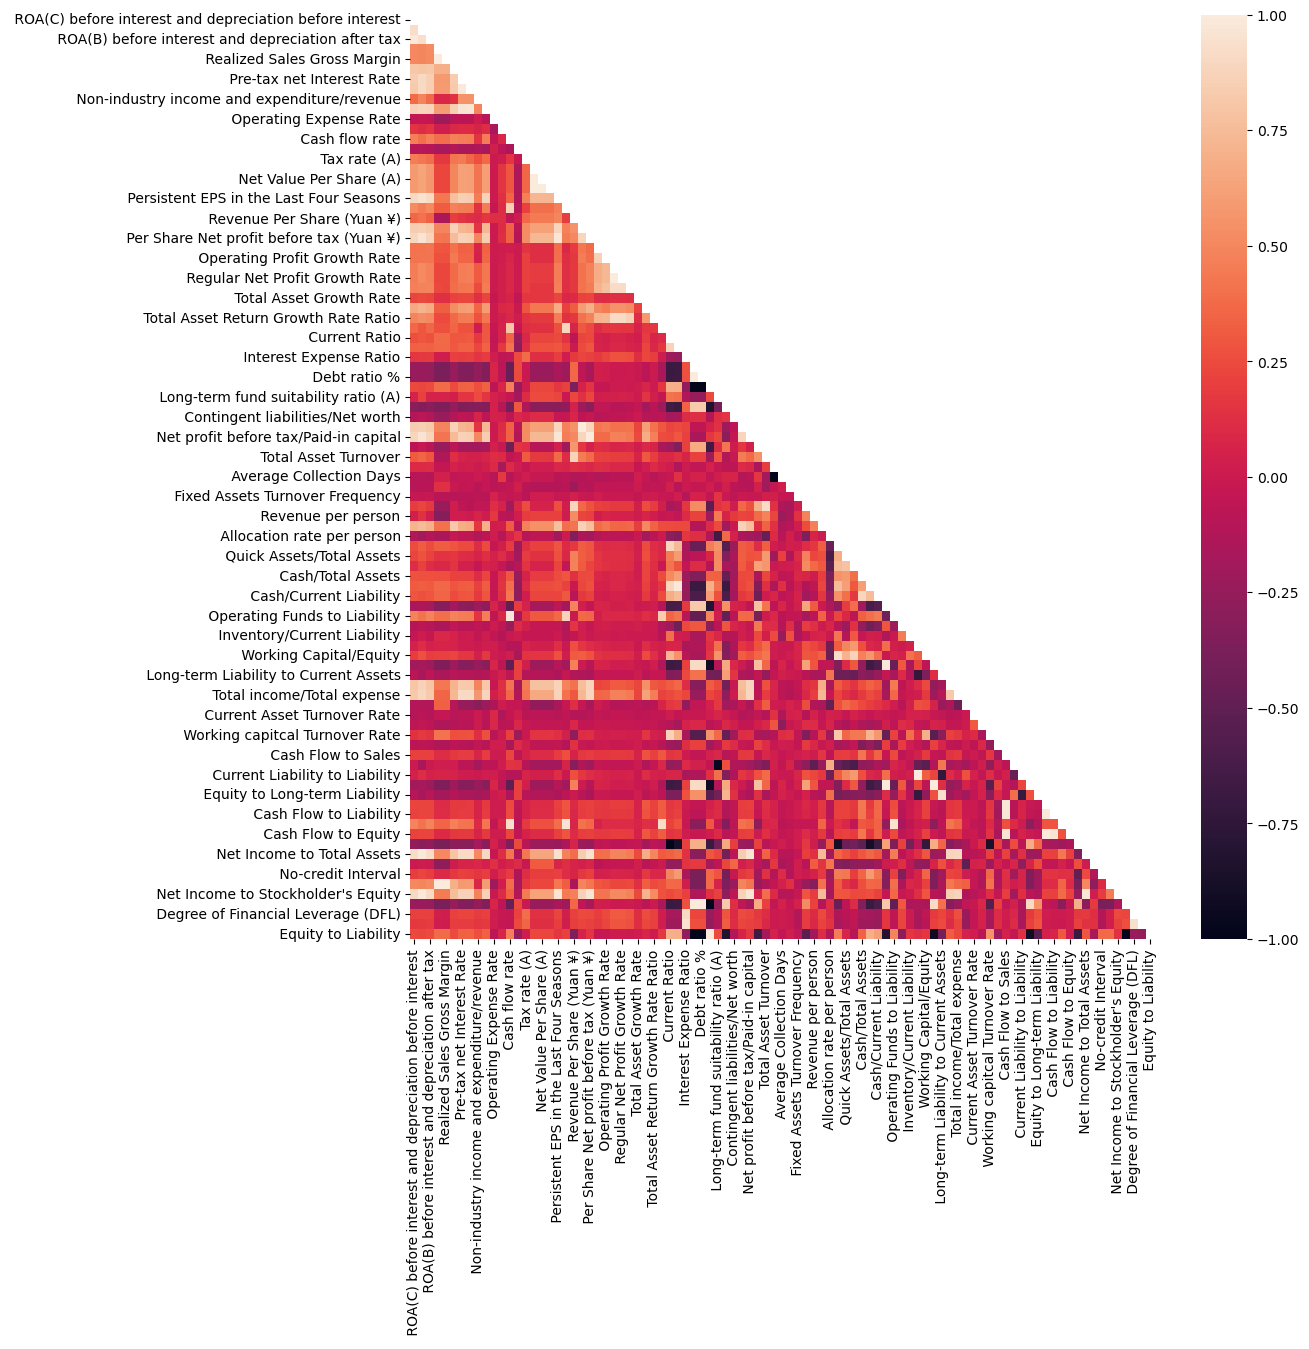

In [15]:
#calculating correlation matrix

corr = df_win.corr('spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=mask)

In [16]:
df_cut = high_corr(df_win)

Removing  ROA(C) before interest and depreciation before interest with 0.95th percentile = -0.26923134487389067
Removing  ROA(B) before interest and depreciation after tax with 0.95th percentile = -0.2717317585323681
Removing  Operating Gross Margin with 0.95th percentile = -0.38068936752085847
Removing  Operating Profit Rate with 0.95th percentile = -0.2613301966896011
Removing  ROA(A) before interest and % after tax with 0.95th percentile = -0.2989602762430868
Removing  Pre-tax net Interest Rate with 0.95th percentile = -0.3340891378811344
Removing  Continuous interest rate (after tax) with 0.95th percentile = -0.3298412243657563
Removing  Net Value Per Share (B) with 0.95th percentile = -0.2740619873619708
Removing  Net Value Per Share (C) with 0.95th percentile = -0.2739282304977576
Removing  Persistent EPS in the Last Four Seasons with 0.95th percentile = -0.24531763857608666
Removing  Cash Flow Per Share with 0.95th percentile = -0.21695616637913726
Removing  Operating Profit Per

In [17]:
df_cut.shape

(5920, 39)

In [18]:
df['Bankrupt?'].value_counts(normalize = True)

Bankrupt?
0    0.967737
1    0.032263
Name: proportion, dtype: float64

In [33]:
cat_cols = df.select_dtypes(include=['int64']).columns[1:]
cat_cols

Index([' Liability-Assets Flag', ' Net Income Flag'], dtype='object')

In [20]:
final_df = pd.concat([df_cut, df[cat_cols], df['Bankrupt?']], axis=1).dropna()
final_df

,Realized Sales Gross Margin,Non-industry income and expenditure/revenue,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (A),Realized Sales Gross Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Current Ratio,Interest Expense Ratio,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Inventory and accounts receivable/Net value,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Allocation rate per person,Quick Assets/Total Assets,Cash/Current Liability,Current Liability to Assets,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Long-term Liability to Current Assets,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Cash Flow to Liability,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Liability-Assets Flag,Net Income Flag,Bankrupt?
0,0.601457,0.302646,1.256969e-04,0.000000e+00,0.458143,0.000725,0.000000,0.147950,0.022102,0.217535,4.980000e+09,0.000327,0.002259,0.629951,0.005024,0.390284,0.006479,0.398036,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.037135,0.166673,1.473360e-04,0.147308,0.276920,0.001036,0.676269,2.559237e-02,0.064856,7.010000e+08,6.550000e+09,4.580000e+08,0.458609,0.716845,0.009219,0.622879,0,1,1
2,0.601364,0.302035,2.361297e-04,2.550000e+07,0.458521,0.000790,0.000000,0.177911,0.022760,0.217601,7.280000e+09,0.000396,0.011543,0.629631,0.005100,0.379093,0.006562,0.406580,0.004227,6.500000e+07,2.650000e+09,0.013387,0.028997,0.141016,0.340201,5.340000e+09,0.098162,0.277456,0.013879,0.446027,3.715116e-03,0.021387,1.791094e-03,1.022676e-03,7.610000e+08,0.459254,0.774670,0.040003,0.623841,0,1,1
3,0.583541,0.303350,1.078888e-04,0.000000e+00,0.465705,0.000449,0.000000,0.154187,0.022046,0.217568,4.880000e+09,0.000382,0.004194,0.630228,0.005047,0.379743,0.005366,0.397925,0.003215,7.130000e+09,9.150000e+09,0.028065,0.015463,0.021320,0.161575,1.010646e-03,0.098715,0.276580,0.003540,0.615848,2.216520e-02,0.024161,8.140000e+09,6.050000e+09,2.030000e+09,0.448518,0.739555,0.003252,0.622929,0,1,1
4,0.598783,0.303475,7.890000e+09,0.000000e+00,0.462746,0.000686,0.000000,0.167502,0.022096,0.217626,5.510000e+09,0.000439,0.006022,0.636055,0.005303,0.375025,0.006624,0.400079,0.004367,1.633674e-04,2.935211e-04,0.040161,0.058111,0.023988,0.260330,6.804636e-04,0.110195,0.287913,0.004869,0.975007,0.000000e+00,0.026385,6.680000e+09,5.050000e+09,8.240000e+08,0.454411,0.795016,0.003878,0.623521,0,1,1
6,0.619950,0.302814,3.984834e-04,7.300000e+08,0.461020,0.000805,0.000000,0.158822,0.022112,0.217604,5.720000e+09,0.000352,0.004672,0.629988,0.005005,0.384999,0.008044,0.400574,0.003805,1.620299e-04,1.452476e-04,0.040806,0.011460,0.009703,0.255093,1.050312e-03,0.115920,0.276643,0.002159,0.508089,9.347426e-03,0.092802,1.058011e-04,9.560000e+09,2.390000e+09,0.457785,0.736619,0.018372,0.623655,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6812,0.613168,0.303543,2.842345e-04,1.305649e-04,0.462196,0.000798,0.297803,0.169399,0.022150,0.217643,6.390000e+09,0.000449,0.012893,0.630703,0.006754,0.369639,0.005366,0.399177,0.002605,7.910000e+09,8.200436e-04,0.033548,0.012714,0.001955,0.221664,7.197433e-03,0.064763,0.277461,0.017426,0.952749,9.270000e+08,0.057486,9.070000e+09,4.440000e+09,5.400000e+09,0.455594,0.806743,0.000548,0.623743,0,1,0
6814,0.604462,0.303510,1.510213e-04,4.500000e+09,0.463734,0.000179,0.113372,0.175045,0.022374,0.217635,7.070000e+09,0.000450,0.010451,0.631415,0.005150,0.373823,0.005366,0.404804,0.009177,4.030000e+07,1.429781e-04,0.027903,0.006348,0.006312,0.312840,5.071548e-03,0.103838,0.277543,0.013212,0.786888,1.792237e-03,0.0

In [21]:
X_train, X_test, y_train, y_test= train_test_split(final_df.drop("Bankrupt?", axis=1),final_df["Bankrupt?"],test_size=0.1, random_state=23)

In [53]:
num_cols_new = df_cut.select_dtypes(include=['float64']).columns

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train[num_cols_new])
X_test_std = scaler.transform(X_test[num_cols_new])

In [51]:
X_train_scaled_df = pd.DataFrame(X_train_std, columns=num_cols_new)
X_test_scaled_df = pd.DataFrame(X_test_std, columns=num_cols_new)

# Concatenating scaled and categorical data
X_train_final = pd.concat([X_train_scaled_df, X_train[cat_cols].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test[cat_cols].reset_index(drop=True)], axis=1)

In [24]:
X_test_final.shape

(592, 41)

In [54]:
X_test_final

,Realized Sales Gross Margin,Non-industry income and expenditure/revenue,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (A),Realized Sales Gross Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Current Ratio,Interest Expense Ratio,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Inventory and accounts receivable/Net value,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Allocation rate per person,Quick Assets/Total Assets,Cash/Current Liability,Current Liability to Assets,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Long-term Liability to Current Assets,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Cash Flow to Liability,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Liability-Assets Flag,Net Income Flag
0,-0.424662,-0.067034,-0.617820,1.162320,1.042474,-0.142715,-0.884366,-0.476523,-0.166265,0.001664,0.160401,-0.425836,1.137052,-0.077696,-0.260678,-0.887908,0.665855,-1.011589,-0.253684,-0.667428,-0.404924,-0.844396,-0.582816,-0.226760,-0.927544,-0.047216,-1.590859,-0.100047,-0.082714,-0.968002,-0.08852,-0.813312,-0.419655,-0.643348,1.780599,-0.077343,-0.390836,-0.194461,0.458263,0,1
1,-0.304338,0.014771,-0.617820,-0.217045,-0.995564,-0.142715,0.535344,-0.137414,-0.004040,0.147817,0.580833,-0.248427,-0.125325,0.255612,-0.136287,0.695707,-0.337885,1.767990,-0.228632,-0.667428,-0.404924,1.557079,-0.057376,-0.477879,0.866683,-0.047216,0.804106,0.025237,-0.082714,-0.144232,-0.08852,1.208341,-0.419655,1.678633,0.507883,-0.102259,-0.205449,-0.233529,0.018286,0,1
2,0.034756,0.535706,-0.617820,0.861788,-0.397761,-0.142715,0.946475,-0.339004,-0.093112,0.088154,0.962401,-0.227688,-0.527717,-0.055356,-0.270323,-0.171864,0.282782,-0.464512,0.046044,1.060800,-0.404924,-0.644809,-0.530605,-0.271343,-0.487546,-0.047216,0.173402,0.140114,-0.082714,0.438899,-0.08852,-0.797951,-0.419655,-0.643348,-0.866111,-0.298483,0.177081,-0.193083,-0.032200,0,1
3,1.408759,0.071707,-0.617820,-0.779580,1.212416,-0.142715,-0.884366,0.190756,-0.076080,0.037099,0.778683,-0.112701,-0.005534,-0.075127,-0.217607,-0.813494,-0.473861,-0.698800,-0.512335,-0.667428,-0.404924,-0.284266,-0.068525,-0.182961,0.940435,-0.047216,-0.173426,-0.105101,-0.082714,1.106169,-0.08852,0.341722,-0.419655,-0.643348,-0.866111,0.410149,1.842700,-0.060403,0.075855,0,1
4,-0.067944,-0.120698,-0.617820,1.489823,0.186435,-0.142715,0.664689,0.411099,-0.058055,0.129149,0.351185,-0.012908,-0.636574,0.132073,-0.360166,0.932440,1.766093,0.281942,0.977503,-0.667428,-0.404924,0.127783,-0.369192,0.115353,-0.053216,-0.047216,0.487775,0.054170,-0.082714,-0.707725,-0.08852,-0.316270,-0.419655,-0.643348,0.777955,0.049798,0.012799,0.072034,-0.057914,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,-0.388200,-0.468206,1.568120,-0.779580,2.539356,-0.142715,-0.884366,-0.451520,-0.184290,-0.007294,-0.422550,-0.535075,-0.065311,-0.386317,-0.148525,0.154346,2.779336,-0.317400,-1.300476,2.273646,-0.404924,0.404629,1.987116,0.281078,-1.181569,-0.047216,-0.835394,0.097194,-0.082714,-1.793133,-0.08852,0.630861,1.504066,-0.636176,-0.356349,-0.006519,-0.615617,-0.209519,-0.003389,0,1
588,-0.370577,0.063200,-0.390272,-0.661678,-0.437952,-0.142715,0.978811,-0.117099,0.161766,0.087787,1.290974,0.110088,-0.470258,0.005073,-0.358734,-0.209184,-0.473861,0.828414,-0.180558,-0.667428,-0.404924,0.926128,-0.072611,-0.023226,0.239244,-0.047216,0.698200,0.053317,-0.082714,0.236313,-0.08852,-0.413898,2.889287,1.566942,-0.312462,-0.083500,0.538113,-0.213389,0.014431,0,1
589,-1.519732,-0.005517,1.089560,-0.779580,-0.344120

In [25]:
X_train_final.shape

(5328, 41)

In [29]:
smote= SMOTE(sampling_strategy='minority', random_state=SEED)
x_train_smote, y_train_smote= smote.fit_resample(X_train_final, y_train)

In [31]:
y_train_smote.value_counts(normalize = True)

Bankrupt?
0    0.5
1    0.5
Name: proportion, dtype: float64

In [55]:
model = LogisticRegression(random_state=SEED)
model.fit(x_train_smote, y_train_smote)
y_pred = model.predict(X_test_final)
probs = model.predict_proba(X_test_final)
accuracy_score(y_test, y_pred)

0.8969594594594594

In [56]:
pd.crosstab(y_pred, y_test, colnames=['Prediction'])

Prediction,0,1
row_0,,
0,516,3
1,58,15


In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       574
           1       0.21      0.83      0.33        18

    accuracy                           0.90       592
   macro avg       0.60      0.87      0.64       592
weighted avg       0.97      0.90      0.93       592



In [70]:
probs

array([[0.99860979, 0.00139021],
       [0.95815561, 0.04184439],
       [0.85774622, 0.14225378],
       ...,
       [0.99251957, 0.00748043],
       [0.04397894, 0.95602106],
       [0.42929161, 0.57070839]])

In [68]:
probs_1 = [probs[i][1] for i in range(len(probs))]

(array([407.,  56.,  29.,  17.,  10.,  15.,  18.,   9.,   9.,  22.]),
 array([2.63785376e-08, 9.99813404e-02, 1.99962654e-01, 2.99943968e-01,
        3.99925282e-01, 4.99906596e-01, 5.99887910e-01, 6.99869224e-01,
        7.99850538e-01, 8.99831852e-01, 9.99813166e-01]),
 <BarContainer object of 10 artists>)

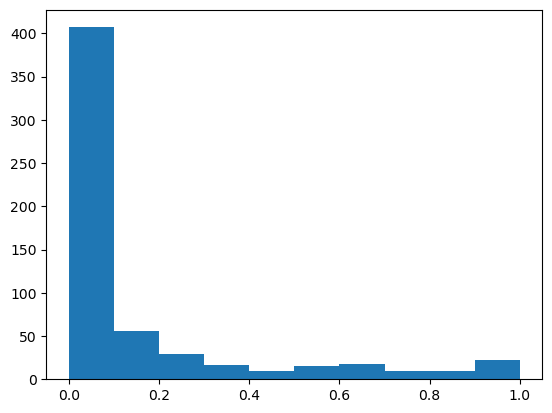

In [69]:
fig, ax = plt.subplots()
ax.hist(probs_1)